In [ ]:
!pip install -q feature_engine
!pip install -q shap

In [ ]:
!pip install -q catboost


In [ ]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/CSV/Software_Professional_Salaries.csv'

# Specify the encoding (e.g., 'ISO-8859-1')
df = pd.read_csv(path, encoding='ISO-8859-1')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Rating,Company Name,Jobs,Salary,Reported,Location
0,3.8,Sasken,Android Developer,400000,3,Bangalore
1,4.5,Advanced Millennium Technologies,Android Developer,400000,3,Bangalore
2,4.0,Unacademy,Android Developer,1000000,3,Bangalore
3,3.8,SnapBizz Cloudtech,Android Developer,300000,3,Bangalore
4,4.4,Appoids Tech Solutions,Android Developer,600000,3,Bangalore


In [ ]:
df["Rating"].nunique()

41

In [ ]:
df["Company Name"].nunique()

11263

In [ ]:
df["Jobs"].nunique()

1084

In [ ]:
df["Salary"].nunique()

316

In [ ]:
df["Location"].unique()

array(['Bangalore', 'Chennai', 'Hyderabad', 'New Delhi', 'Pune', 'Jaipur',
       'Kerala', 'Kolkata', 'Madhya Pradesh', 'Mumbai'], dtype=object)

In [ ]:
print("Mean Salary:", round(df["Salary"].mean()))
print("Median Salary:", round(df["Salary"].median()))
print("Highest Salary:", round(df["Salary"].max()))
print("Lowest Salary:", round(df["Salary"].min()))

Mean Salary: 695361
Median Salary: 500000
Highest Salary: 90000000
Lowest Salary: 2112


In [ ]:
# select label and convert it to Lakh INR
label = 'Salary'
df[label] = df[label]*1e-5
# Exclude 1% of smallest and 1% of highest salaries
P = np.percentile(df[label], [1, 99])
df = df[(df[label] > P[0]) & (df[label] < P[1])]
# replace selected job titles
titles_dict = {'Software Development Engineer (SDE)': 'Software Development Engineer',
              'Software Development Engineer (SDE) II': 'Senior Software Development Engineer',
              'Software Development Engineer I': 'Software Development Engineer',
              'Software Development Engineer II': 'Senior Software Development Engineer',
              'IOS Applications Developer': 'IOS Developer',
              'Software Engineer (Ios Developer)': 'IOS Developer',
              'IOS Software Developer': 'IOS Developer',
              'Software Development Engineer (SDE) - Intern': 'Software Development Engineer - Intern',
              'Java Software Developer': 'Java Developer',
              'Software Engineer - Java Developer': 'Java Developer',
              'Front End Web Developer': 'Web Developer',
              'Software Test Engineer': 'Test Engineer',
              'Software Engineer, Backend': 'Backend Engineer',
              'Software Development Engineer In Test (SDET)': 'Software Development Engineer In Test',
              'Software Development Engineer In Test (SDET) II': 'Senior Software Development Engineer In Test',
              'Database Administrator (Database Administrator)': 'Database Administrator',
              'Software Development Engineer (SDE1)': 'Software Development Engineer'}
df['Jobs'] = df['Jobs'].replace(titles_dict)
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['Company Name', 'Jobs', 'Location']:
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=30, replace_with='Other', tol=20/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
# drop unused columns
print(df.shape)

(22289, 6)


In [ ]:
df.sample(10).T

,7823,20758,11728,12606,18451,2960,8155,11746,11931,8207
Rating,3.8,3.7,4.1,4.0,4.1,4.0,4.4,4.5,4.1,3.8
Company Name,Other,Other,Other,Other,Other,Deloitte,Other,Google,Other,Other
Jobs,IOS Developer,Other,Python Developer,Software Development Engineer - Intern,Software Development Engineer,Backend Developer,IOS Developer,Other,Software Development Engineer,Senior IOS Developer
Salary,3.0,3.0,2.4,1.0,10.0,9.0,2.64,5.76,10.0,9.0
Reported,2,2,1,1,1,1,1,1,1,1
Location,New Delhi,Hyderabad,Hyderabad,Bangalore,New Delhi,Bangalore,New Delhi,Hyderabad,Bangalore,New Delhi


In [ ]:
df.describe()

,Rating,Salary,Reported
count,22289.000000,22289.000000,22289.000000
mean,3.917352,6.598013,1.840056
std,0.518923,5.157861,6.406377
min,1.000000,0.823680,1.000000
25%,3.700000,3.000000,1.000000
50%,3.900000,5.000000,1.000000
75%,4.200000,9.000000,1.000000
max,5.000000,30.000000,361.000000


In [ ]:
df['Company Name'].value_counts()

Other                             19758
Tata Consultancy Services           268
Amazon                              173
Infosys                             169
Accenture                           149
Cognizant Technology Solutions      143
Wipro                               122
IBM                                 121
Fresher                             101
Capgemini                           101
HCL Technologies                    101
Microsoft                            88
Google                               77
Tech Mahindra                        76
First Student                        73
Oracle                               64
ABC                                  64
Mindtree                             60
Dell Technologies                    55
Freelancer                           54
LTI                                  49
DONE by NONE                         48
Wipro Technologies                   48
Anonymous                            43
Deloitte                             42


In [ ]:
print(df.columns)


Index(['Rating', 'Company Name', 'Jobs', 'Salary', 'Reported', 'Location'], dtype='object')


In [ ]:
# initialize data
y = df[label].values.reshape(-1,)
X = df.drop([label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11144, 5), (11145, 5), (11144,), (11145,))

In [ ]:
from catboost import Pool, CatBoostRegressor, CatBoostError, CatBoost

# initialize Pool
train_pool = Pool(X_train, y_train, cat_features=cat_cols_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_cols_idx)

# specify the training parameters
model = CatBoostRegressor(iterations=1000, depth=7, verbose=0, learning_rate=0.01, loss_function='RMSE')

# train the model
model.fit(train_pool)

# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,3)} Lakh INR, and for test {round(rmse_test,3)} Lakh INR")



RMSE score for train 4.591 Lakh INR, and for test 4.684 Lakh INR


In [ ]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,3)} Lakh INR, and for test {round(rmse_bs_test,3)} Lakh INR")

RMSE baseline score for train 5.147 Lakh INR, and for test 5.169 Lakh INR


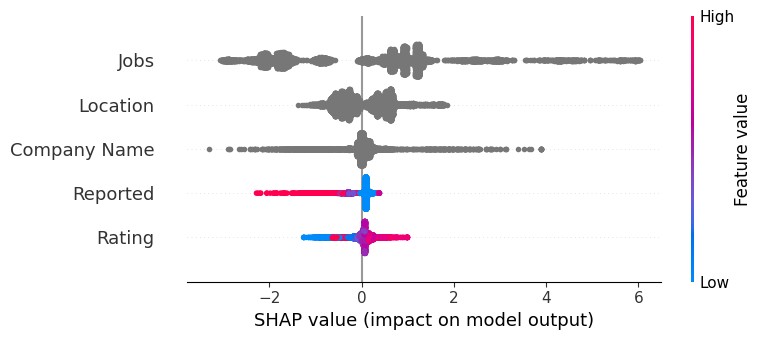

In [ ]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
expected_values = ex.expected_value
print(f"Average predicted salary is {round(expected_values,3)} Lakh INR")
print(f"Average actual salary is {round(np.mean(y_test),3)} Lakh INR")

Average predicted salary is 6.606 Lakh INR
Average actual salary is 6.591 Lakh INR


RMSE baseline score for train 5.147 Lakh INR, and for test 5.169 Lakh INR
RMSE score for train 4.839 Lakh INR, and for test 4.947 Lakh INR


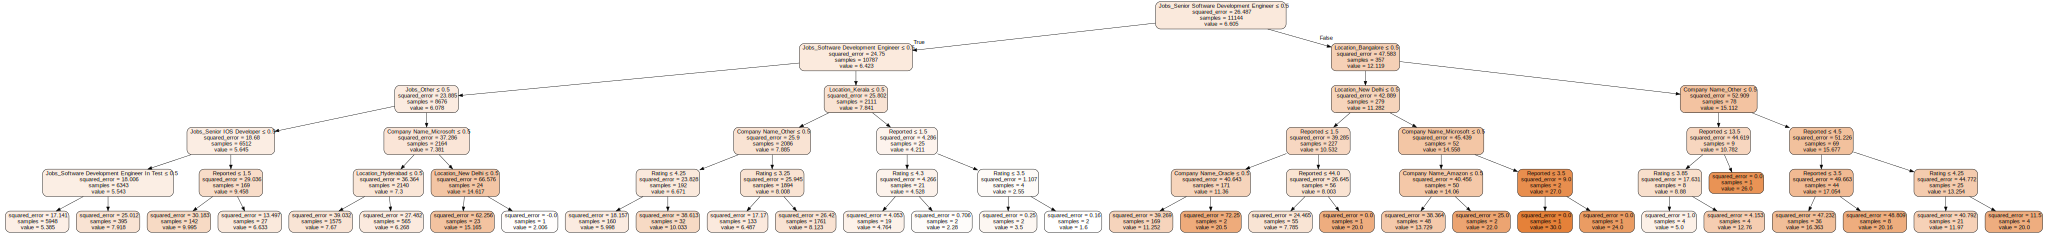

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import graphviz

# Assuming cat_cols_idx is a list of indices of categorical columns
categorical_columns = X_train.columns[cat_cols_idx]

# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)] * len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train, 3)} Lakh INR, and for test {round(rmse_bs_test, 3)} Lakh INR")

# One-hot encode categorical features
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns)

# Train a DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train_encoded, y_train)

# Make predictions
y_train_pred = model.predict(X_train_encoded)
y_test_pred = model.predict(X_test_encoded)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train, 3)} Lakh INR, and for test {round(rmse_test, 3)} Lakh INR")

# Export the decision tree to Graphviz format
dot_data = export_graphviz(model, out_file=None,
                           feature_names=X_train_encoded.columns,
                           filled=True, rounded=True, special_characters=True)

# Save the decision tree in PNG format
graph = graphviz.Source(dot_data, format='png')
graph.render("decision_tree", cleanup=True)
graph



Rating



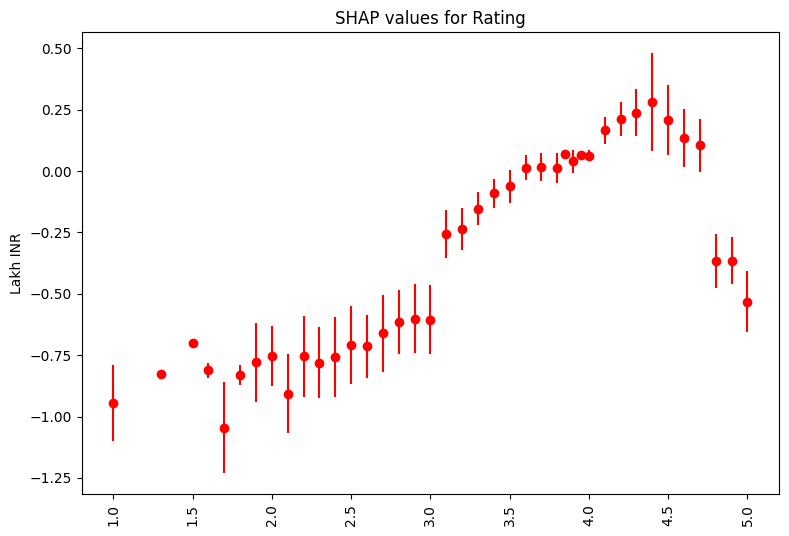

         gain  gain_std  count
col                           
4.40  0.28038   0.19892    415
4.30  0.23776   0.09480    651
4.20  0.21197   0.06915    643
4.50  0.20720   0.14144    454
4.10  0.16592   0.05526   1028
4.60  0.13496   0.11884    225
4.70  0.10442   0.10846    191
3.85  0.06835   0.00646      6
3.95  0.06518   0.00238     19
4.00  0.06221   0.02327   1392
3.90  0.03982   0.04744   1240
3.70  0.01587   0.05550    740
3.60  0.01347   0.05065    487
3.80  0.01316   0.06098   1197
3.50 -0.06220   0.06711    364
3.40 -0.09147   0.05953    277
3.30 -0.15446   0.06692    334
3.20 -0.23527   0.08482    174
3.10 -0.25577   0.09759    179
4.90 -0.36606   0.09591     74
4.80 -0.36837   0.11023    142
5.00 -0.53250   0.12471    327
2.90 -0.60104   0.14064     76
3.00 -0.60567   0.14102    166
2.80 -0.61505   0.13064     65
2.70 -0.66173   0.15677     52
1.50 -0.69861       NaN      1
2.50 -0.70692   0.15874     33
2.60 -0.71342   0.12883     38
2.00 -0.75372   0.12380     20
2.20 -0.

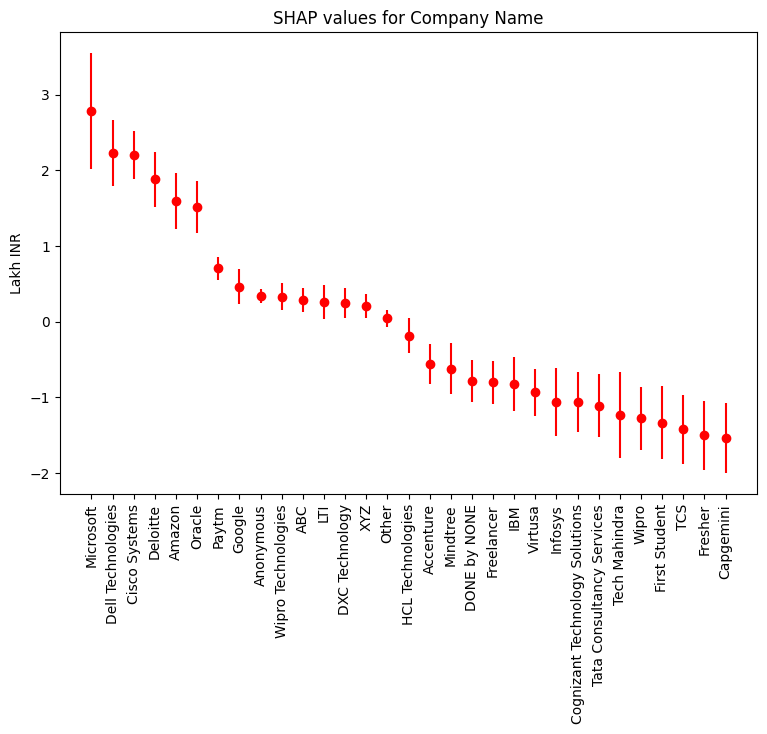

                                   gain  gain_std  count
col                                                     
Microsoft                       2.78474   0.76299     46
Dell Technologies               2.22575   0.43976     29
Cisco Systems                   2.20215   0.31717     20
Deloitte                        1.88190   0.36250     17
Amazon                          1.59376   0.37226     95
Oracle                          1.51402   0.33922     31
Paytm                           0.70619   0.15086     16
Google                          0.46214   0.22896     47
Anonymous                       0.33697   0.09233     23
Wipro Technologies              0.32916   0.18047     24
ABC                             0.28495   0.15598     40
LTI                             0.25395   0.22498     27
DXC Technology                  0.24989   0.19624     22
XYZ                             0.20818   0.15959     24
Other                           0.04302   0.11427   9862
HCL Technologies               

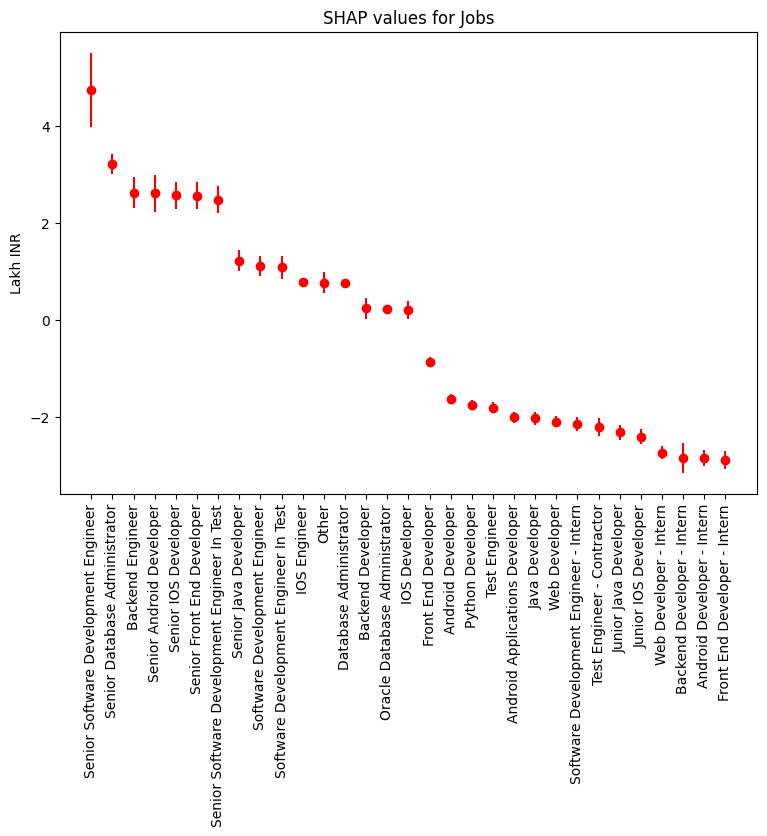

                                                 gain  gain_std  count
col                                                                   
Senior Software Development Engineer          4.73355   0.76888    379
Senior Database Administrator                 3.20378   0.21026     27
Backend Engineer                              2.61907   0.32264    105
Senior Android Developer                      2.60582   0.37823    135
Senior IOS Developer                          2.56209   0.26937    179
Senior Front End Developer                    2.55839   0.27329     41
Senior Software Development Engineer In Test  2.47618   0.28387     74
Senior Java Developer                         1.21975   0.20937    146
Software Development Engineer                 1.11042   0.19639   2165
Software Development Engineer In Test         1.08371   0.24224    441
IOS Engineer                                  0.78123   0.09083     45
Other                                         0.77026   0.21674   2094
Databa

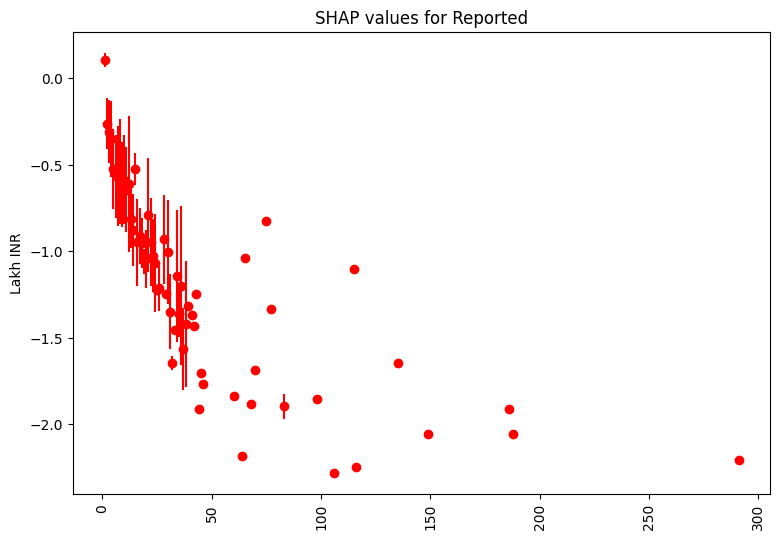

        gain  gain_std  count
col                          
1    0.10479   0.03988   8852
2   -0.26318   0.14758   1208
3   -0.30950   0.18387    400
4   -0.35484   0.21902    190
5   -0.52605   0.23162    114
15  -0.52669   0.09260      6
8   -0.53861   0.30397     36
7   -0.56692   0.28828     52
6   -0.56856   0.23975     71
10  -0.58712   0.25781     25
12  -0.61159   0.39434     10
9   -0.61473   0.24298     36
11  -0.64427   0.24460     15
21  -0.79127   0.32744      7
13  -0.81194   0.17134     10
75  -0.82319       NaN      1
14  -0.87916   0.20772      7
17  -0.91183   0.16202      7
28  -0.93048   0.25643      3
22  -0.94688   0.25504      4
16  -0.94951   0.25355      6
18  -0.95077   0.14384      7
30  -1.00596   0.29890      5
23  -1.02591   0.20940      7
65  -1.04054       NaN      1
20  -1.04459   0.16581      2
19  -1.05933   0.07443      4
24  -1.06964   0.28169      6
115 -1.10511       NaN      1
34  -1.14419   0.38099      3
36  -1.19824   0.45706      2
26  -1.214

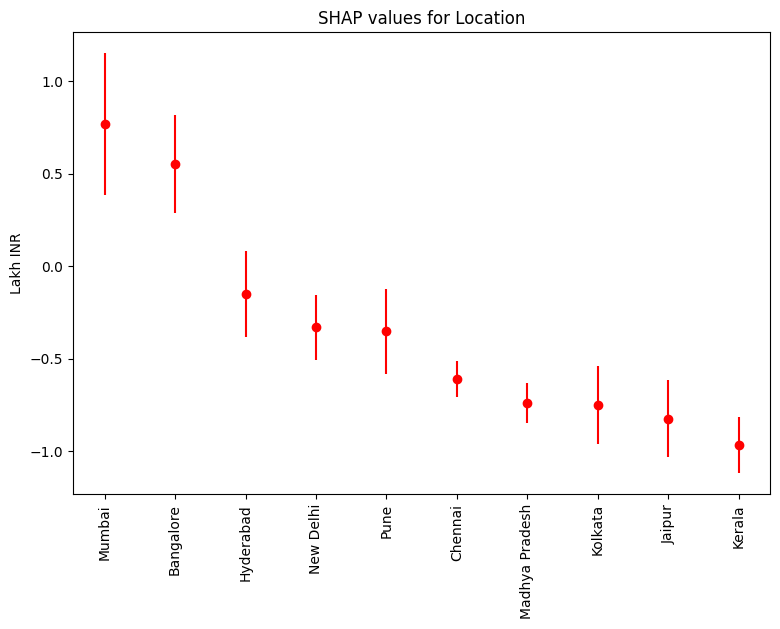

                   gain  gain_std  count
col                                     
Mumbai          0.76752   0.38375    361
Bangalore       0.55308   0.26563   4069
Hyderabad      -0.14973   0.23156   2144
New Delhi      -0.33119   0.17704   2028
Pune           -0.35310   0.22853   1065
Chennai        -0.61027   0.09916   1209
Madhya Pradesh -0.73725   0.10826     79
Kolkata        -0.74867   0.21080     92
Jaipur         -0.82440   0.20901     43
Kerala         -0.96588   0.15185     55


In [ ]:
def show_shap(col, shap_values=shap_values):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],5)
    gain_std = round(df_infl.groupby(col).std()['shap_'],5)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(9,6))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for {col}')
    plt.ylabel('Lakh INR')
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    print()
    print(col)
    print()
    show_shap(col, shap_values)

In [ ]:
!pip install -q wordcloud
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS


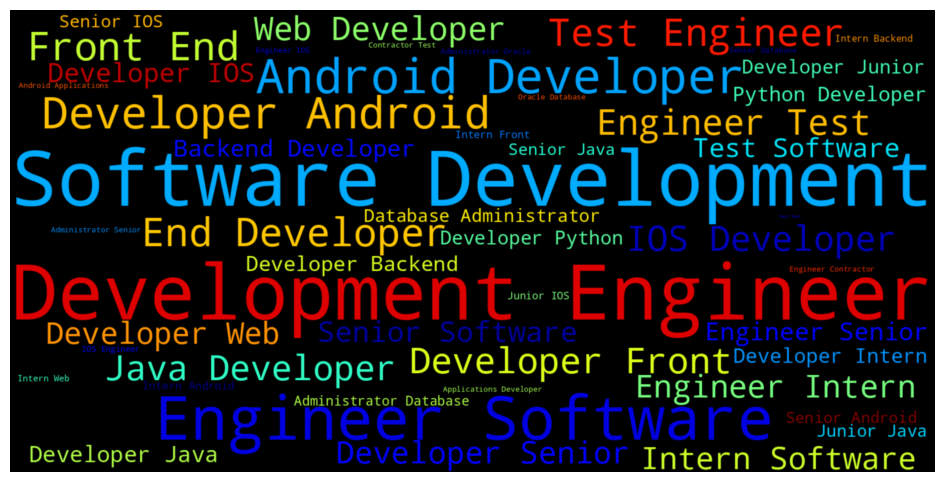

In [ ]:
text = " ".join(Company for Company in df["Jobs"])
#font = "Quicksand-Bold.ttf"
word_cloud = WordCloud(width = 1600,
                       height = 800,
                       colormap = 'jet',
                       background_color = "black").generate(text)
plt.figure(figsize = (30, 6))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

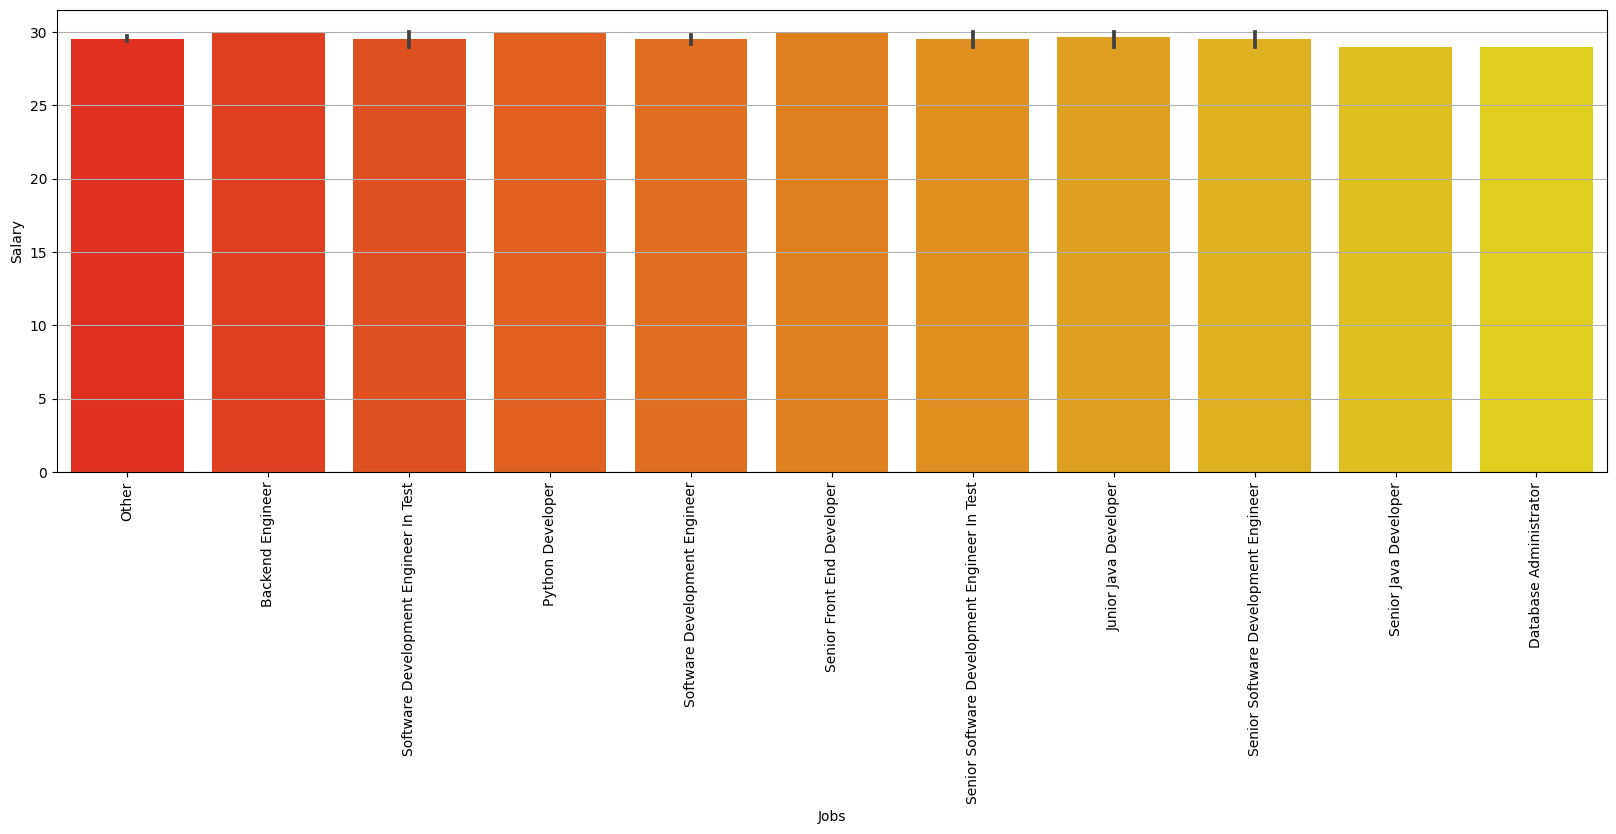

In [ ]:
#bar plot for top 50 salaries
plt.figure(figsize = (20, 6))
plt.grid()
plt.xticks(rotation = 90)
plt.ticklabel_format(style = 'plain')
df.sort_values("Salary", axis = 0,
                         ascending = False,
                         inplace = True)
sns.barplot(x = df["Jobs"][:50],
            y = df["Salary"],
            palette = "autumn");

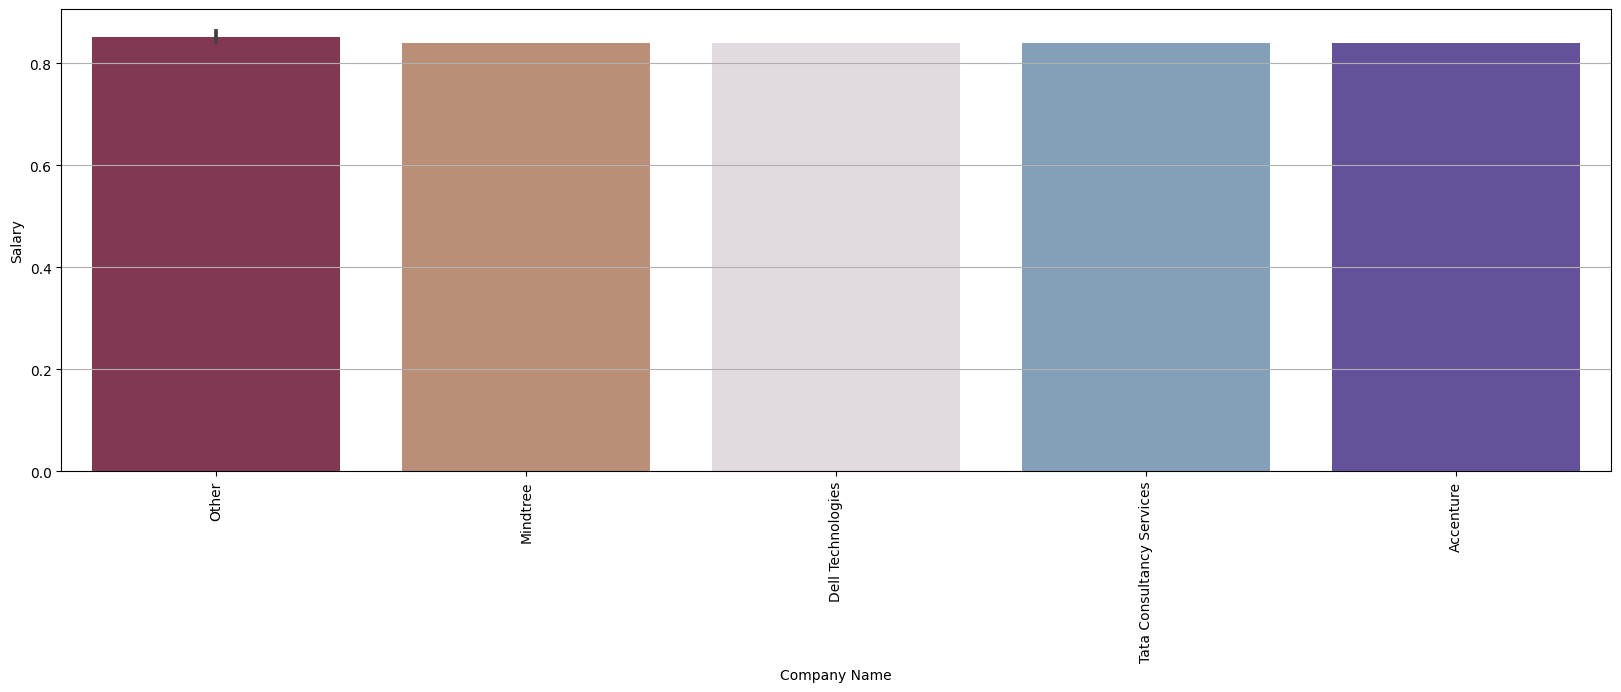

In [ ]:
#company name vs top 50 lowest salaries
plt.figure(figsize = (20, 6))
plt.grid()
plt.xticks(rotation = 90)
plt.ticklabel_format(style = 'plain')
df.sort_values("Salary", axis = 0, ascending = True, inplace = True)
sns.barplot(x = df["Company Name"][:50], y = df["Salary"], palette = "twilight_shifted_r");

In [ ]:
#scatter plot for rating vs jobs
fig = px.scatter(df, x = "Rating", y = "Jobs", color = "Rating")
fig.show()

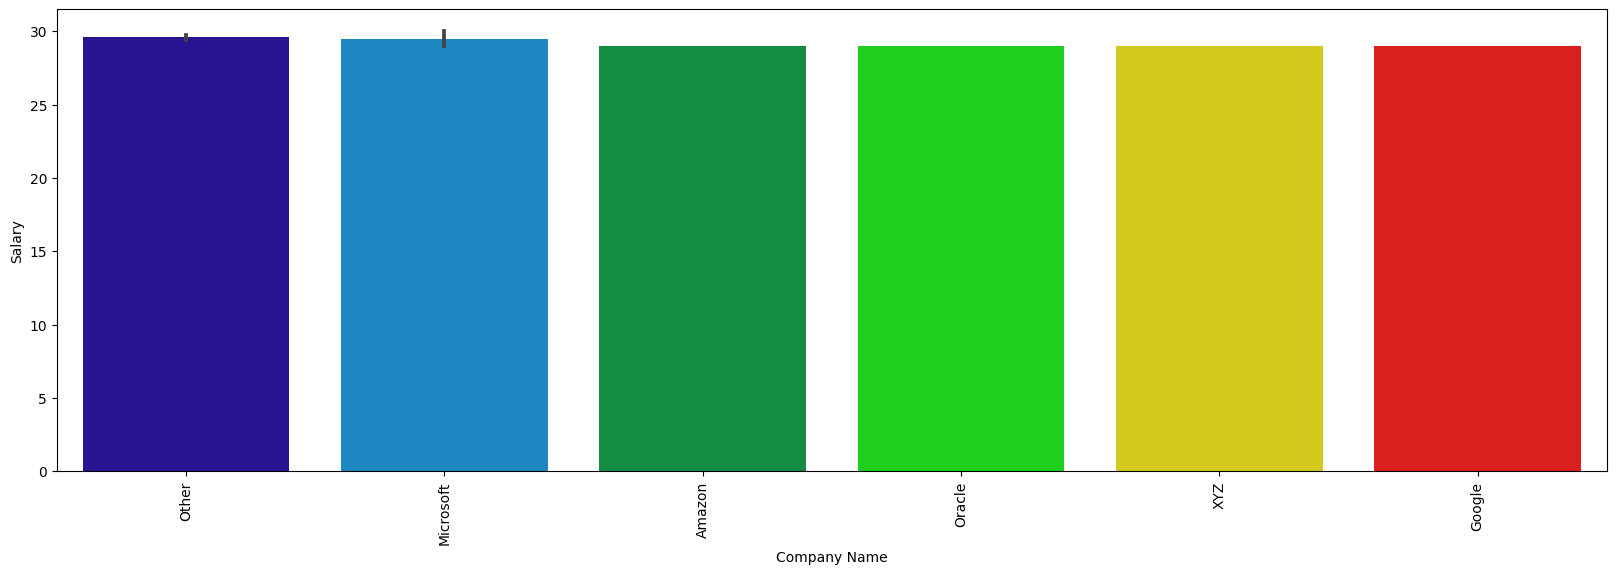

In [ ]:
#comapny name vs salary parallel
plt.figure(figsize = (20, 6))
plt.xticks(rotation = 90)
plt.ticklabel_format(style = 'plain')
df.sort_values("Salary", axis = 0, ascending = False, inplace = True)
sns.barplot(x = df["Company Name"][1:51],
            y = df["Salary"][1:51],
            palette = "nipy_spectral");

In [ ]:
x =df[['Rating',  'Jobs', 'Salary', 'Reported']].values
x
y = df[['Location']].values
y

array([['Bangalore'],
       ['Hyderabad'],
       ['Bangalore'],
       ...,
       ['Hyderabad'],
       ['Hyderabad'],
       ['Bangalore']], dtype=object)

In [ ]:
#handling the missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer( missing_values = np.nan, strategy = "mean" ) #creating variable
imputer = imputer.fit(x[:,2:3])
x[:,2:3]=imputer.transform(x[:,2:3])
x

array([[4.0, 'Other', 30.000000000000004, 1],
       [4.0, 'Other', 30.000000000000004, 1],
       [4.4, 'Senior Front End Developer', 30.000000000000004, 1],
       ...,
       [4.2, 'Other', 0.8400000000000001, 1],
       [4.5, 'Other', 0.8400000000000001, 1],
       [4.4, 'Other', 0.8236800000000001, 1]], dtype=object)

In [ ]:
#converting categorical values into digits
from sklearn.preprocessing import LabelEncoder
label_encoder_x=LabelEncoder()
x[:,1]= label_encoder_x.fit_transform(x[:,1])
x

array([[4.0, 15, 30.000000000000004, 1],
       [4.0, 15, 30.000000000000004, 1],
       [4.4, 19, 30.000000000000004, 1],
       ...,
       [4.2, 15, 0.8400000000000001, 1],
       [4.5, 15, 0.8400000000000001, 1],
       [4.4, 15, 0.8236800000000001, 1]], dtype=object)

In [ ]:
label_encoder_y=LabelEncoder()
y[:,0]= label_encoder_y.fit_transform(y[:,0])
y

array([[0],
       [2],
       [0],
       ...,
       [2],
       [2],
       [0]], dtype=object)

In [ ]:
#dummy encoding
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
x = onehotencoder.fit_transform(df.Jobs.values.reshape(-1,1)).toarray()
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])